In [1]:
import numpy as np 
import scipy as sp
from file_parser import *
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt

# ANF Output Analysis
We make time domain plots, frequency domain analysis, plot spectograms and perform statistical analysis of the signal. We used varied test signals including coffee shop background noise, electric hums, rain and ventilation sounds.

In [9]:
input_coffeeshop = reads('../CCS_StartFiles/Assignment_2/data/CoffeeShop.pcm')/(2**15)
output_coffeeshop = reads('../CCS_StartFiles/Assignment_2/data/CoffeeShop-trimmed.pcm')/(2**15)
input_ventilation = reads('../CCS_StartFiles/Assignment_2/data/ventilation.pcm')/(2**15)
output_ventilation = reads('../CCS_StartFiles/Assignment_2/data/Ventilation-trimmed.pcm')/(2**15)

# C and ASM Implementation Comparison
We implemented the 2nd order adaptive notch filter (ANF) in both C and assembly.

In [2]:
input_signal = reads('../CCS_StartFiles/Assignment_2/data/input.pcm')
output_c = reads('../CCS_StartFiles/Assignment_2/data/output_c.pcm')
output_c_adaptive = reads('../CCS_StartFiles/Assignment_2/data/output_c_adaptive.pcm')
output_asm = reads('../CCS_StartFiles/Assignment_2/data/output_asm.pcm')
output_asm_adaptive = reads('../CCS_StartFiles/Assignment_2/data/output_asm_adaptive.pcm')

The input signal itself is 

## Time Domain Analysis

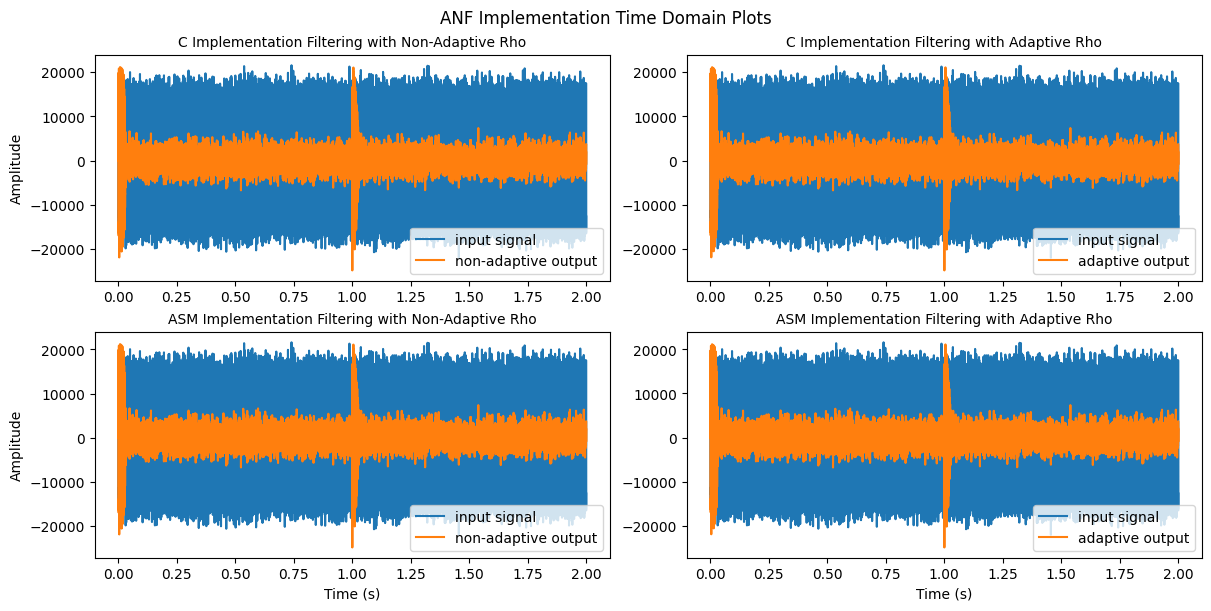

In [90]:
Fs = 8000
time = np.arange(0, len(input_signal)) / Fs

fig = plt.figure(layout='constrained', figsize=(12,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.suptitle('ANF Implementation Time Domain Plots')

ax1.plot(time, input_signal, label="input signal")
ax1.plot(time, output_c, label="non-adaptive output")
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.set_title("C Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax2.plot(time, input_signal, label="input signal")
ax2.plot(time, output_c_adaptive, label="adaptive output")
ax2.legend()
ax2.set_title("C Implementation Filtering with Adaptive Rho", fontsize=10)

ax3.plot(time, input_signal, label="input signal")
ax3.plot(time, output_asm, label="non-adaptive output")
ax3.set_ylabel('Amplitude')
ax3.set_xlabel('Time (s)')
ax3.legend()
ax3.set_title("ASM Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax4.plot(time, input_signal, label="input signal")
ax4.plot(time, output_asm_adaptive, label="adaptive output")
ax4.set_xlabel('Time (s)')
ax4.legend()
ax4.set_title("ASM Implementation Filtering with Adaptive Rho", fontsize=10)

plt.show()

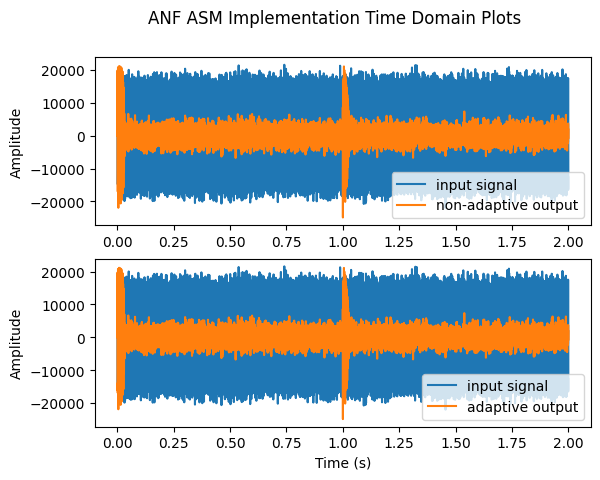

In [29]:
Fs = 8000
time = np.arange(0, len(input_signal)) / Fs

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('ANF ASM Implementation Time Domain Plots')

ax1.plot(time, input_signal, label="input signal")
ax1.plot(time, output_asm, label="non-adaptive output")
ax1.set_ylabel('Amplitude')
ax1.legend()

ax2.plot(time, input_signal, label="input signal")
ax2.plot(time, output_asm_adaptive, label="adaptive output")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.legend()

plt.show()

## Frequency Domain Analysis

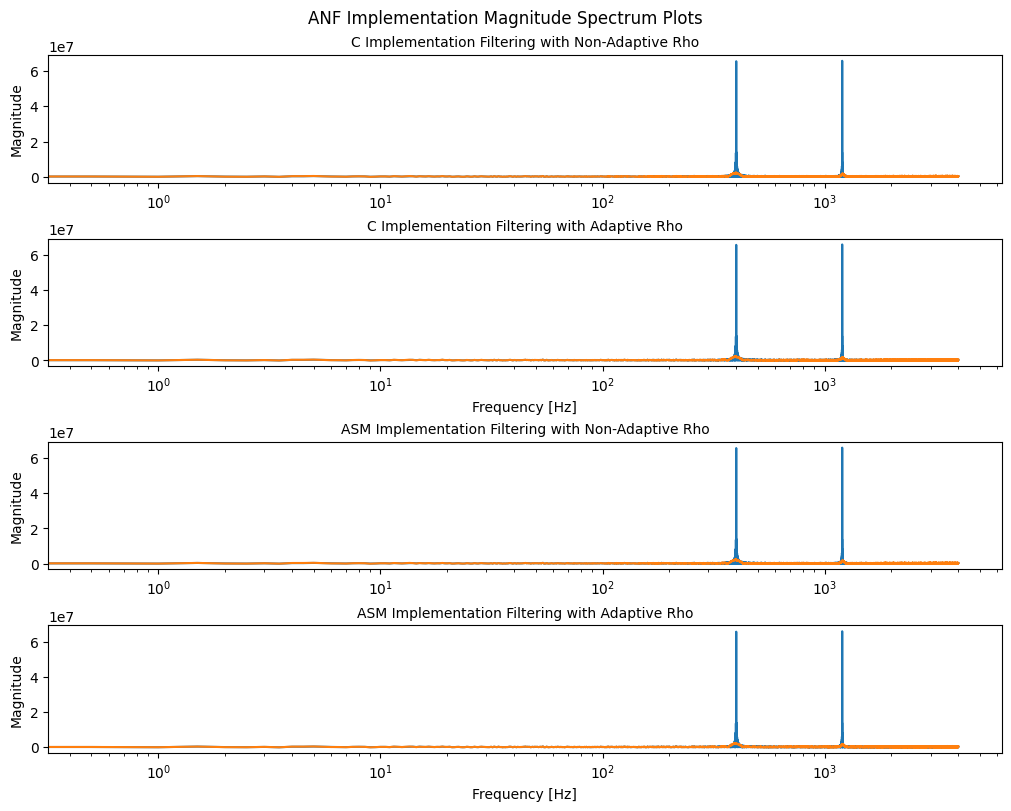

In [76]:
input_fft = np.fft.fft(input_signal)
input_freqs = np.fft.fftfreq(len(input_signal)) * Fs
output_c_fft = np.fft.fft(output_c)
output_c_freqs = np.fft.fftfreq(len(output_c)) * Fs
output_c_adaptive_fft = np.fft.fft(output_c_adaptive)
output_c_freqs_adaptive = np.fft.fftfreq(len(output_c_adaptive)) * Fs
output_asm_fft = np.fft.fft(output_asm)
output_asm_freqs = np.fft.fftfreq(len(output_asm)) * Fs
output_asm_adaptive_fft = np.fft.fft(output_asm_adaptive)
output_asm_adaptive_freqs = np.fft.fftfreq(len(output_asm_adaptive)) * Fs

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, layout='constrained', figsize=(10, 8))
fig.suptitle('ANF Implementation Magnitude Spectrum Plots')

ax1.plot(freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2], label='input signal')
ax1.plot(freqs[:len(output_c_freqs)//2], np.abs(output_c_fft)[:len(output_c_fft)//2], label='non-adaptive output')
ax1.set_ylabel('Magnitude')
ax1.set_xscale('log')
ax1.set_title("C Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax2.plot(freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2], label='input signal')
ax2.plot(freqs[:len(output_c_freqs_adaptive)//2], np.abs(output_c_adaptive_fft)[:len(output_c_adaptive_fft)//2], label='adaptive output')
ax2.set_ylabel('Magnitude')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_xscale('log')
ax2.set_title("C Implementation Filtering with Adaptive Rho", fontsize=10)

ax3.plot(freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2])
ax3.plot(freqs[:len(output_asm_freqs)//2], np.abs(output_asm_fft)[:len(output_asm_fft)//2])
ax3.set_ylabel('Magnitude')
ax3.set_xscale('log')
ax3.set_title("ASM Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax4.plot(freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2])
ax4.plot(freqs[:len(output_asm_adaptive_freqs)//2], np.abs(output_asm_adaptive_fft)[:len(output_asm_adaptive_fft)//2])
ax4.set_ylabel('Magnitude')
ax4.set_xscale('log')
ax4.set_xlabel('Frequency [Hz]')
ax4.set_title("ASM Implementation Filtering with Adaptive Rho", fontsize=10)


plt.show()

## Spectograms

Text(0.5, 1.0, 'Spectrogram Before Any Filtering')

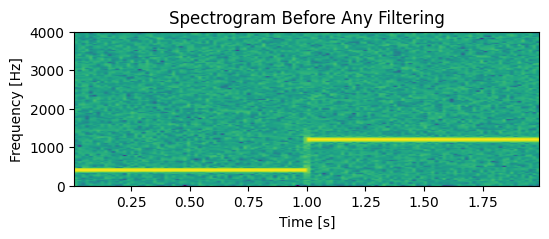

In [70]:
plt.figure(figsize=(6,2))
plt.specgram(input_signal, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram Before Any Filtering")

ValueError: not enough values to unpack (expected 4, got 2)

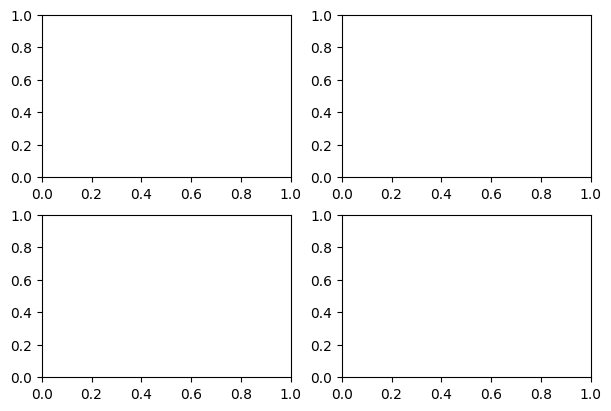

In [77]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(2, 2, layout='constrained', figsize=(6, 4))
fig.suptitle('ANF C Implementation Post-Filtering Spectogram')

ax1.specgram(output_c, Fs=8000)
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title("After Filtering with Non-Adaptive Rho", fontsize=10)

ax2.specgram(output_c_adaptive, Fs=8000)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("After Filtering with Adaptive Rho", fontsize=10)

ax3.specgram(output_asm, Fs=8000)
ax3.set_ylabel("Frequency [Hz]")
ax3.set_title("After Filtering with Non-Adaptive Rho", fontsize=10)

ax4.specgram(output_asm_adaptive, Fs=8000)
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Frequency [Hz]")
ax4.set_title("After Filtering with Adaptive Rho", fontsize=10)

plt.show()

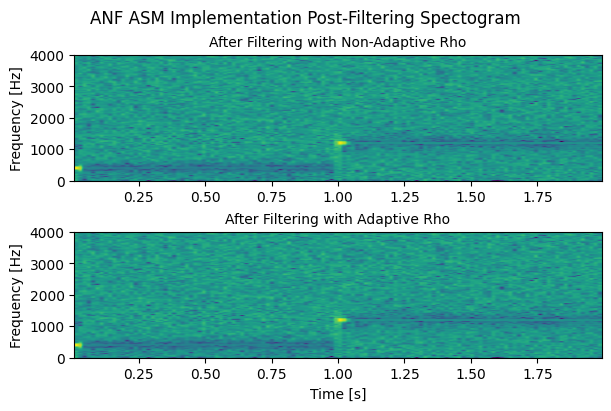

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained', figsize=(6, 4))
fig.suptitle('ANF ASM Implementation Post-Filtering Spectogram')

ax1.specgram(output_asm, Fs=8000)
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title("After Filtering with Non-Adaptive Rho", fontsize=10)

ax2.specgram(output_asm_adaptive, Fs=8000)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("After Filtering with Adaptive Rho", fontsize=10)

plt.show()

## Statistical Analysis

In [56]:
print("-------------------------------------------")
print("INPUT SIGNAL")
print(f"Mean: {np.mean(input_signal)}")
print(f"Standard Deviation: {np.std(input_signal)}")
print(f"Max: {np.max(input_signal)}")
print(f"Min: {np.min(input_signal)}")
print("-------------------------------------------")
print("OUTPUT C")
print(f"Mean: {np.mean(output_c)}")
print(f"Standard Deviation: {np.std(output_c)}")
print(f"Max: {np.max(output_c)}")
print(f"Min: {np.min(output_c)}")
print("-------------------------------------------")
print("OUTPUT ASM")
print(f"Mean: {np.mean(output_asm)}")
print(f"Standard Deviation: {np.std(output_asm)}")
print(f"Max: {np.max(output_asm)}")
print(f"Min: {np.min(output_asm)}")
print("-------------------------------------------")

-------------------------------------------
INPUT SIGNAL
Mean: 5.212875
Standard Deviation: 11710.713969974642
Max: 21595
Min: -22009
-------------------------------------------
OUTPUT C
Mean: 7.035
Standard Deviation: 2696.6874056006195
Max: 21183
Min: -24870
-------------------------------------------
OUTPUT ASM
Mean: 2.7569375
Standard Deviation: 2698.5275615570654
Max: 21191
Min: -24877
-------------------------------------------


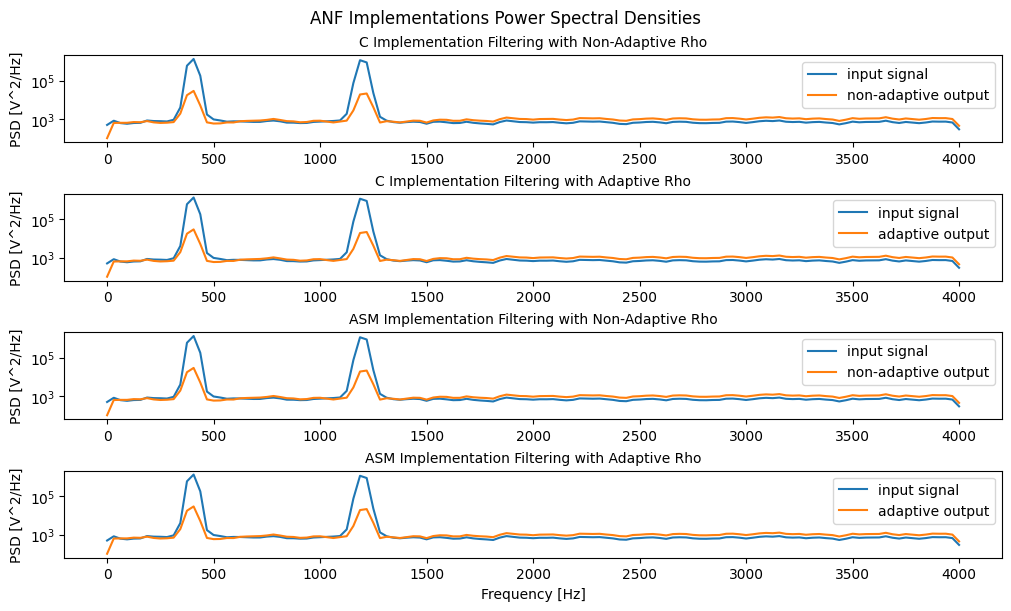

In [65]:
input_f, input_Pxx = signal.welch(input_signal, Fs)
output_c_f, output_c_Pxx = signal.welch(output_c, Fs)
output_c_adaptive_f, output_c_adaptive_Pxx = signal.welch(output_c_adaptive, Fs)
output_asm_f, output_asm_Pxx = signal.welch(output_asm, Fs)
output_asm_adaptive_f, output_asm_adaptive_Pxx = signal.welch(output_asm_adaptive, Fs)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, layout='constrained', figsize=(10, 6),)
fig.suptitle('ANF Implementations Power Spectral Densities')

ax1.semilogy(input_f, input_Pxx, label="input signal")
ax1.semilogy(output_c_f, output_c_Pxx, label="non-adaptive output")
ax1.set_title('C Implementation Filtering with Non-Adaptive Rho', fontsize=10)
ax1.set_ylabel('PSD [V^2/Hz]')
ax1.legend()

ax2.semilogy(input_f, input_Pxx, label="input signal")
ax2.semilogy(output_c_adaptive_f, output_c_adaptive_Pxx, label="adaptive output")
ax2.set_title('C Implementation Filtering with Adaptive Rho', fontsize=10)
ax2.set_ylabel('PSD [V^2/Hz]')
ax2.legend()

ax3.semilogy(input_f, input_Pxx, label="input signal")
ax3.semilogy(output_asm_f, output_asm_Pxx, label="non-adaptive output")
ax3.set_title('ASM Implementation Filtering with Non-Adaptive Rho', fontsize=10)
plt.xlabel('Frequency [Hz]')
ax3.set_ylabel('PSD [V^2/Hz]')
ax3.legend()

ax4.semilogy(input_f, input_Pxx, label="input signal")
ax4.semilogy(output_asm_adaptive_f, output_asm_Pxx, label="adaptive output")
ax4.set_title('ASM Implementation Filtering with Adaptive Rho', fontsize=10)
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('PSD [V^2/Hz]')
ax4.legend()

plt.show()